In [ ]:
import pandas as pd

def convert_csv_format(input_csv_path, output_csv_path):
    # Read the CSV into a DataFrame
    df = pd.read_csv(input_csv_path)
    
    # Extract the total duration from the first row's Timestamp
    total_duration = float(df['Timestamp'].iloc[0].split('/')[1])
    
    # Subtract 0.3 from dysfluency time to account for reaction time
    df['Timestamp'] = df['Timestamp'].apply(lambda x: f"{float(x.split('/')[0]) - 0.4}/{x.split('/')[1]}")
    
    # Calculate the number of chunks
    num_chunks = int(total_duration // 3) + (1 if total_duration % 3 > 0 else 0)
    
    # Initialize the prediction dictionary with all chunks as fluent (1)
    predictions = {f"chunk_{i}.wav": 1 for i in range(num_chunks)}
    
    # Mark chunks containing a dysfluent moment as 0
    for index, row in df.iterrows():
        dysfluent_time = float(row['Timestamp'].split('/')[0])
        chunk_index = int(dysfluent_time // 3)
        predictions[f"chunk_{chunk_index}.wav"] = 0
    
    # Convert the dictionary to a DataFrame
    predictions_df = pd.DataFrame(list(predictions.items()), columns=['ChunkName', 'Prediction'])
    
    # Write the new CSV file
    predictions_df.to_csv(output_csv_path, index=False)

# filename = 'MSTP - Ollie 2.csv'
# filename = 'MSLP - Ollie.csv'
# filename = 'MSLP - JAG.csv'
filename = 'MSLP - Harry.csv'
filename = 'MSLP - Andrea.csv'
convert_csv_format(f'Marks\Raw\{filename}', f'Marks\Processed+ReactionTime\{filename}')


In [ ]:
import os
import pandas as pd

def merge_csv_files(directory):
    # Get a list of all CSV files in the directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    
    # Initialize a dictionary to store predictions for each file
    predictions_dict = {}
    
    # Iterate over each CSV file
    for file in csv_files:
        # Read the CSV file into a DataFrame
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        # Set the 'ChunkName' column as the index
        df.set_index('ChunkName', inplace=True)
        
        # Update the predictions dictionary with predictions from this file
        predictions_dict[file] = df['Prediction']
    
    # Convert the predictions dictionary to a DataFrame
    merged_df = pd.DataFrame(predictions_dict)
    
    # Reset the index to add 'ChunkName' as a column
    merged_df.reset_index(inplace=True)
    
    # Rename the 'index' column to 'ChunkName'
    merged_df.rename(columns={'index': 'ChunkName'}, inplace=True)
    
    # Write the merged DataFrame to a new CSV file
    merged_csv_path = os.path.join(directory, 'merged_predictions.csv')
    merged_df.to_csv(merged_csv_path, index=False)
    
    print(f"Merged predictions saved to: {merged_csv_path}")


merge_csv_files('Marks\Processed+ReactionTime')

In [5]:
import pandas as pd
# Read the CSV file into a DataFrame
csv_file_path = 'Marks\Processed+ReactionTime\merged_predictions.csv'
df = pd.read_csv(csv_file_path)

# Exclude the 'ChunkName' column for calculating the average
prediction_cols = df.columns[1:]

# Calculate the average across columns
df['Average'] = df[prediction_cols].mean(axis=1).round().astype(int)

# Save the DataFrame to a new CSV file
output_csv_path = csv_file_path.replace('.csv', '_with_average.csv')
df.to_csv(output_csv_path, index=False)

print(f"New CSV file with average column saved to: {output_csv_path}")

New CSV file with average column saved to: Marks\Processed+ReactionTime\merged_predictions_with_average.csv


In [9]:
import pandas as pd

def merge_csv_files(merged_csv_path, new_csv_path):
    # Read the merged CSV file into a DataFrame
    merged_df = pd.read_csv(merged_csv_path)
    
    # Read the new CSV file into a DataFrame
    new_df = pd.read_csv(new_csv_path)
    
    # Set the 'ChunkName' column as the index for both DataFrames
    merged_df.set_index('ChunkName', inplace=True)
    new_df.set_index('ChunkName', inplace=True)
    
    # Merge the DataFrames on 'ChunkName'
    merged_df = merged_df.join(new_df, how='outer', lsuffix='_merged', rsuffix='_new')
    
    # Drop any duplicate columns (except for the index column)
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    
    # Reset the index to add 'ChunkName' as a column
    merged_df.reset_index(inplace=True)
    
    # Write the merged DataFrame to a new CSV file
    output_csv_path = merged_csv_path.replace('.csv', '_merged.csv')
    merged_df.to_csv(output_csv_path, index=False)
    
    print(f"Merged predictions saved to: {output_csv_path}")

# Example usage:
merge_csv_files(r'Marks\Processed+ReactionTime\merged_predictions_with_average.csv', r'C:\Users\ojmar\Documents\Uni\Synoptic Project\StammerScore\ML Models\combined-and-filtered-strict-Binary-RandF-gpu-optimised\My Stuttering Life Podcast Presents - My Journey From PWS To PWSS\chunk_predictions.csv')


Merged predictions saved to: Marks\Processed+ReactionTime\merged_predictions_with_average_merged.csv


In [21]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

def calculate_cohen_kappa(df):
    cohen_kappa_values_model = {}
    cohen_kappa_values_average = {}
    cohen_kappa_values_pairs = []
    
    # Added for calculating Cohen's Kappa between each human and the model
    cohen_kappa_values_human_model = {}

    # Iterate over each column (except 'ChunkName', 'Human Average', and 'Model Prediction')
    for column in df.columns[1:-2]:
        # Scenario 1: Each human against the model
        cohen_kappa_values_model[column] = cohen_kappa_score(df[column], df['Model Prediction'])

        # Scenario 2: Each human against the average human score
        cohen_kappa_values_average[column] = cohen_kappa_score(df[column], df['Human Average'])
        
        # Scenario 4: Each human against the model
        cohen_kappa_values_human_model[column] = cohen_kappa_score(df[column], df['Human Average'])

    # Scenario 3: Between all pairs of human raters
    human_columns = df.columns[1:-3]  # Exclude 'ChunkName', 'Human Average', and 'Model Prediction'
    for i, human1 in enumerate(human_columns):
        for j, human2 in enumerate(human_columns):
            if i != j:
                cohen_kappa_values_pairs.append(cohen_kappa_score(df[human1], df[human2]))
            else:
                cohen_kappa_values_pairs.append(None)

    # Convert the list to a square matrix
    size = len(human_columns)
    cohen_kappa_matrix_pairs = [cohen_kappa_values_pairs[i:i+size] for i in range(0, len(cohen_kappa_values_pairs), size)]

    # Calculate the average Cohen's Kappa value for scenario 3
    average_kappa_pairs = sum(cohen_kappa_values_pairs) / len(cohen_kappa_values_pairs)
    
    # Calculate the average Cohen's Kappa value between all humans and the ML model
    average_kappa_human_model = sum(cohen_kappa_values_human_model.values()) / len(cohen_kappa_values_human_model)

    return cohen_kappa_values_model, cohen_kappa_values_average, cohen_kappa_matrix_pairs, average_kappa_human_model

def print_cohen_kappa_table(cohen_kappa_values):
    df = pd.DataFrame(cohen_kappa_values.items(), columns=['Comparison', 'Cohen\'s Kappa'])
    print(df)

def print_cohen_kappa_matrix(cohen_kappa_matrix):
    df = pd.DataFrame(cohen_kappa_matrix, columns=df.columns[1:-3], index=df.columns[1:-3])
    print("Cohen's Kappa values - Between all pairs of human raters:")
    print(df)

# Example usage:
file_path = "Marks\Processed+ReactionTime\merged_predictions_with_average_merged.csv"
df = pd.read_csv(file_path)

cohen_kappa_values_model, cohen_kappa_values_average, cohen_kappa_matrix_pairs, average_kappa_human_model = calculate_cohen_kappa(df)

print("Cohen's Kappa values - Each human against the model:")
print_cohen_kappa_table(cohen_kappa_values_model)

print("\nCohen's Kappa values - Between all pairs of human raters:")
print_cohen_kappa_matrix(cohen_kappa_matrix_pairs)

print(f"\nAverage Cohen's Kappa value between all pairs of human raters: {average_kappa_pairs:.3f}")

# Print average Cohen's Kappa value between all humans and the ML model
print(f"\nAverage Cohen's Kappa value between all humans and the ML model: {average_kappa_human_model:.3f}")


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [14]:
from sklearn.metrics import cohen_kappa_score

# Assuming you have the average human scores and model predictions stored in variables
average_human_scores = df['Human Average']
model_predictions = df['Model Prediction']

# Calculate Cohen's Kappa between average human scores and model predictions
cappa_average_vs_model = cohen_kappa_score(average_human_scores, model_predictions)

print("Cohen's Kappa between Average Human and Model Prediction:", cappa_average_vs_model)


Cohen's Kappa between Average Human and Model Prediction: 0.11066195048004046


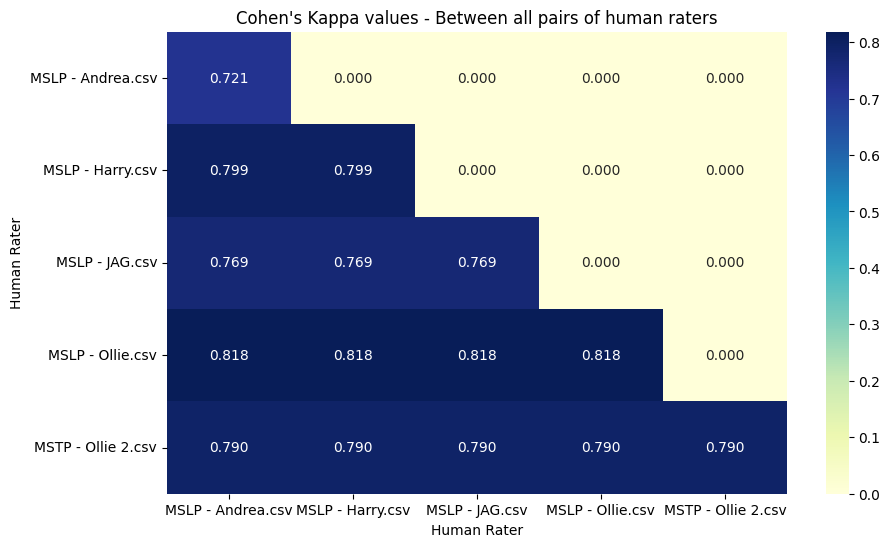

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Cohen's Kappa values between all pairs of human raters
cohen_kappa_values_pairs_data = {
    "Comparison": ["MSLP - Andrea.csv", "MSLP - Harry.csv", "MSLP - JAG.csv", "MSLP - Ollie.csv", "MSTP - Ollie 2.csv"],
    "MSLP - Andrea.csv": [0.721365, 0.798732, 0.768705, 0.818347, 0.789706],
    "MSLP - Harry.csv": [0, 0.798732, 0.768705, 0.818347, 0.789706],
    "MSLP - JAG.csv": [0, 0, 0.768705, 0.818347, 0.789706],
    "MSLP - Ollie.csv": [0, 0, 0, 0.818347, 0.789706],
    "MSTP - Ollie 2.csv": [0, 0, 0, 0, 0.789706]
}

# Convert the data to a DataFrame
cohen_kappa_values_pairs_df = pd.DataFrame(cohen_kappa_values_pairs_data)

# Set the 'Comparison' column as the index
cohen_kappa_values_pairs_df.set_index('Comparison', inplace=True)

# Create a heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(cohen_kappa_values_pairs_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Cohen's Kappa values - Between all pairs of human raters")
plt.xlabel("Human Rater")
plt.ylabel("Human Rater")
plt.show()
